In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html baseline
import torchaudio
from pathlib import Path
Path('../data/raw').mkdir(parents=True, exist_ok=True)
sc_dataset = torchaudio.datasets.SPEECHCOMMANDS('../data/raw', download=True)

In [3]:
!pip install opencv-python

Spec - min 0.00 max 6.47


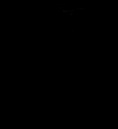

Spec - min 0.00 max 4.45


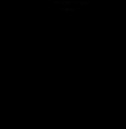

Spec - min 0.00 max 21.94


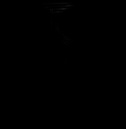

Spec - min 0.00 max 57.74


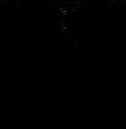

Spec - min 0.00 max 4.60


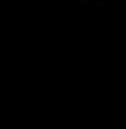

Spec - min 0.00 max 728.29


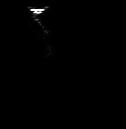

Spec - min 0.00 max 434.42


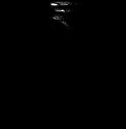

Spec - min 0.00 max 3.94


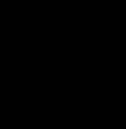

Spec - min 0.00 max 207.93


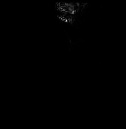

Spec - min 0.00 max 8.71


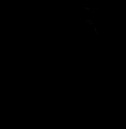

In [5]:
N_SAMPLES = 10
N_FFT = 256
import IPython.display as ipd
import torch
import cv2

for idx in range(N_SAMPLES):
    waveform, sample_rate, label, speaker_id, utterance_id = val_set[idx]
    sound = ipd.Audio(waveform, rate=sample_rate)
    transform = torchaudio.transforms.Spectrogram(n_fft=N_FFT)
    spec = torch.moveaxis(transform(waveform), 0, -1)
    print(f"Spec - min {spec.min():.2f} max {spec.max():.2f}")
    _spec = spec.detach().cpu().numpy()
    _,ret = cv2.imencode('.jpg', _spec) 
    img = ipd.Image(data=ret)
    ipd.display(sound)
    ipd.display(img)

In [6]:
!pip install umap-learn

# Display the UMAP manifold for random samples from the validation set.

In [14]:
import umap
from torchvision.transforms import Resize
import numpy as np
X = []
y = []
label_set = set([])
N_SAMPLES = 1000
IS_RANDOM = False
val_size = len(val_set)
# Randomly index N_SAMPLES from the validation set and plot the umap manifold.
import random

for idx in range(N_SAMPLES):
    if IS_RANDOM:
        idx = int(random.random() * val_size)
    waveform, sample_rate, label, speaker_id, utterance_id = val_set[idx]
    label_set.add(label)
    sound = ipd.Audio(waveform, rate=sample_rate)
    transform = torchaudio.transforms.Spectrogram(n_fft=N_FFT)
    spec = torch.moveaxis(transform(waveform), 0, -1)
    
    _spec = spec.detach().cpu().numpy()
    X.append(Resize((32,32))(spec).flatten())
    y.append(list(label_set).index(label))
X = np.stack(X, axis=0)
y = np.array(y)
manifold = umap.UMAP().fit(X, y)
X_reduced = manifold.transform(X)

In [17]:
label_list = list(label_set)
_y = [label_list[s] for s in y]

In [9]:
X_reduced.shape

(1000, 2)

In [10]:
!pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 12.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 12.6 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.1 MB/s eta 0:00:000m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 12.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 12.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 12.5 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 970.0/970.0 kB 10.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.3 MB/s eta 0:00:0031m13.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 12.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59422 sha256=af8aaac658fc9cbca94907ff80c621611fff671fb4a6f627d5aa8d333cec8315
  Stored in directory: /home/sparkitny/.cache/pip/wheels/a5/e6/3b/e622b30d2b4fd64bfdc3c2e1b0b1c8bfda485342d0a7abcb48
Successfully built datashape


# Ordered samples from UMAP

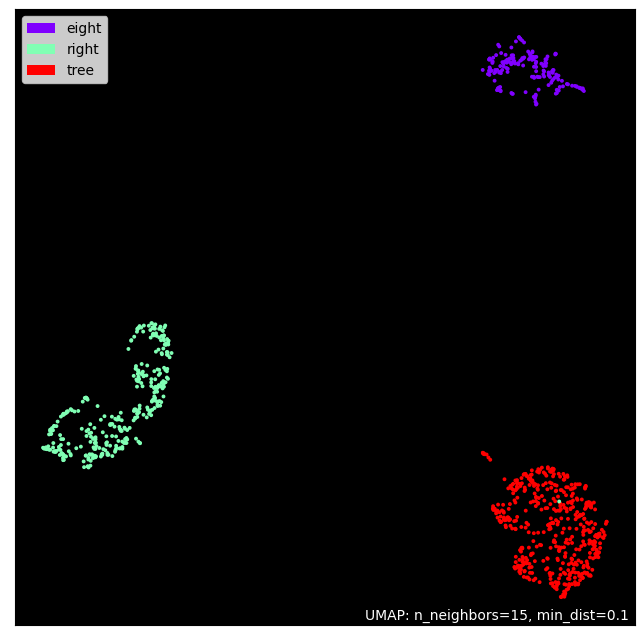

In [20]:
import umap.plot  # pip install umap-learn[plot]

umap.plot.points(manifold, labels=np.array(_y), theme="fire");

In [ ]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);